# Multilevel Elasticities for a Single SKU - Part III.

In this notebook we continue our simulation study for elasticities, see [Multilevel Elasticities for a Single SKU - Part I](https://juanitorduz.github.io/multilevel_elasticities_single_sku/) and [Multilevel Elasticities for a Single SKU - Part II](https://juanitorduz.github.io/multilevel_elasticities_single_sku_2/) for an introduction to the problem and some models. In this notebook we extend the covariance model to allow two covariance components on both the intercepts and slopes (coefficient of the `median_ income` variable). Also, to abstract from a specific framework, we do the implementation in [NumPyro](https://num.pyro.ai/). The corresponding [PyMC](https://docs.pymc.io/) is very similar.

## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import polars as pl
import seaborn as sns
from jax import random
from numpyro.infer import MCMC, NUTS
from sklearn.preprocessing import LabelEncoder

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Read Data

We read the data from cour case study. YOu can find an explicit data generating process in the first notebook [Multilevel Elasticities for a Single SKU - Part I](https://juanitorduz.github.io/multilevel_elasticities_single_sku/).

In [2]:
market_df = pl.read_csv(
    "https://raw.githubusercontent.com/juanitorduz/website_projects/master/data/multilevel_elasticities_single_sku_data.csv",
    schema_overrides={"region_id": pl.Categorical},
)

market_df.head()

item_id,price,quantities,time_step,store_id,region_store_id,region_id,median_income,log_price,log_quantities
i64,f64,f64,i64,i64,str,cat,f64,f64,f64
0,1.335446,6.170862,16,0,"""r-0_s-0""","""0""",5.873343,0.289265,1.819839
0,1.702792,3.715124,15,0,"""r-0_s-0""","""0""",5.873343,0.532269,1.312412
0,1.699778,3.290962,14,0,"""r-0_s-0""","""0""",5.873343,0.530498,1.19118
0,1.335844,5.702928,13,0,"""r-0_s-0""","""0""",5.873343,0.289563,1.74098
0,1.517213,4.264949,12,0,"""r-0_s-0""","""0""",5.873343,0.416875,1.45043


Recall that our objective is to estimate the elasticity of a single SKU across different regions.

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


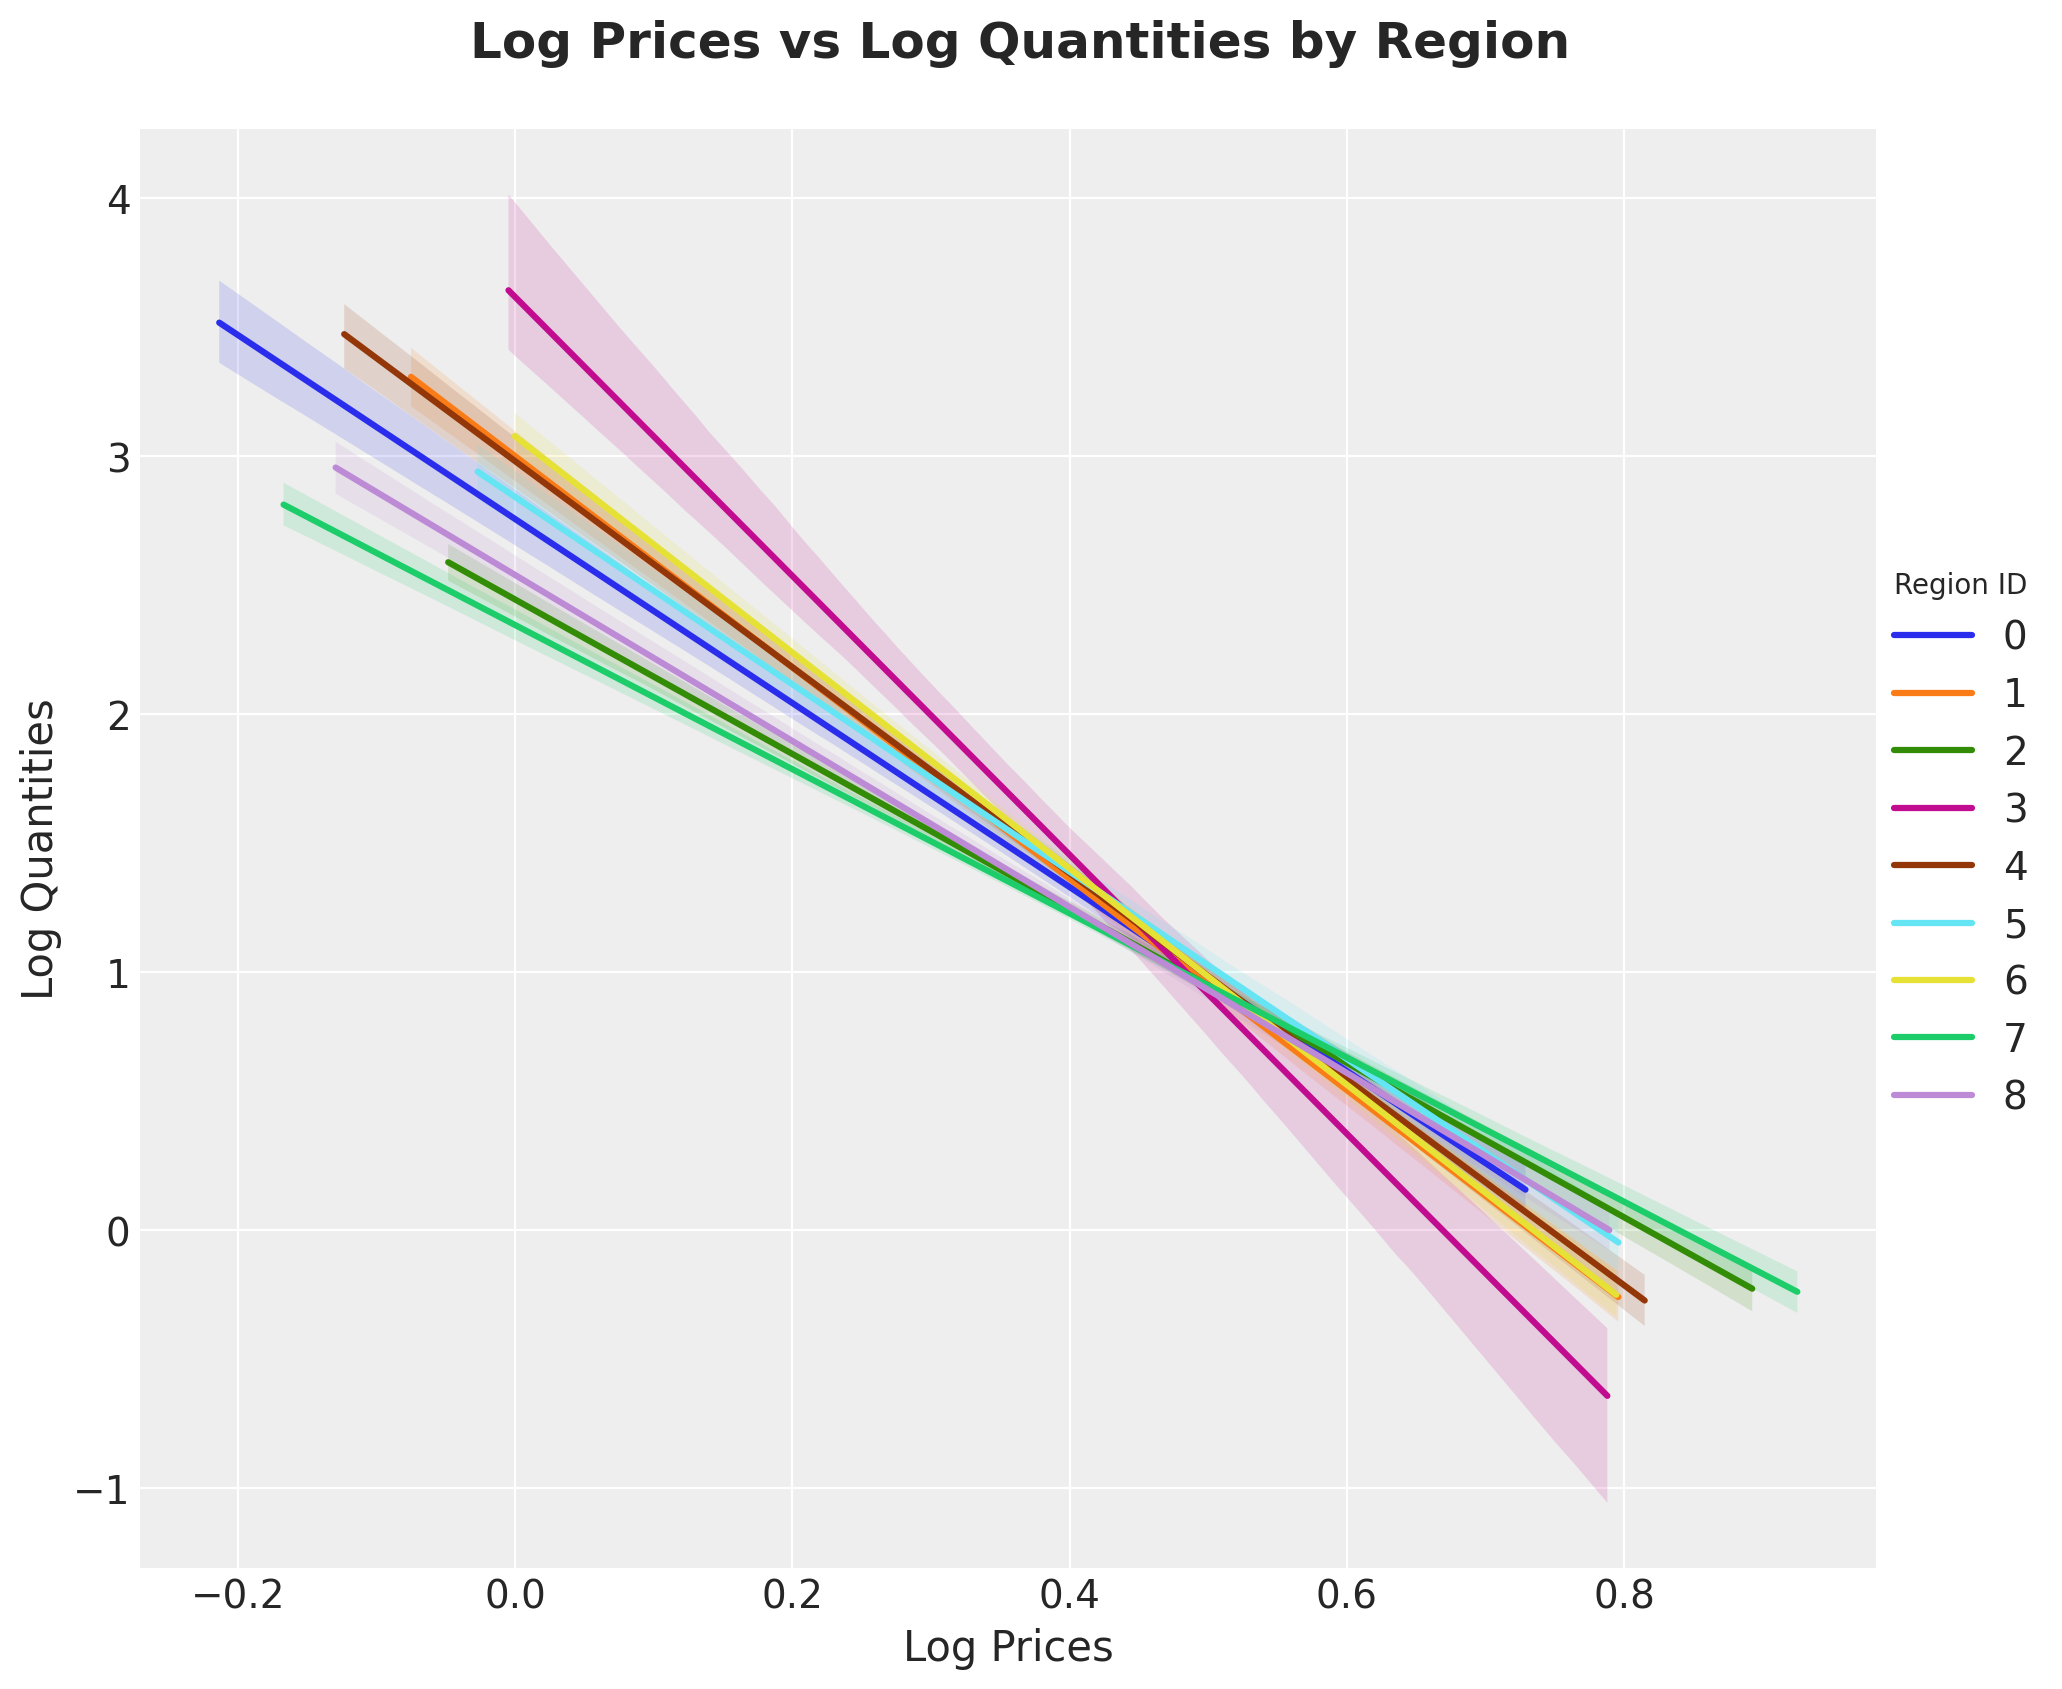

In [3]:
g = sns.lmplot(
    data=market_df,
    x="log_price",
    y="log_quantities",
    hue="region_id",
    height=8,
    aspect=1.2,
    scatter=False,
)
g.set_axis_labels(x_var="Log Prices", y_var="Log Quantities")
legend = g.legend
legend.set_title(title="Region ID", prop={"size": 10})
g.fig.suptitle(
    "Log Prices vs Log Quantities by Region", y=1.05, fontsize=18, fontweight="bold"
);

 We expect this elasticity to be influenced by the region's median income.

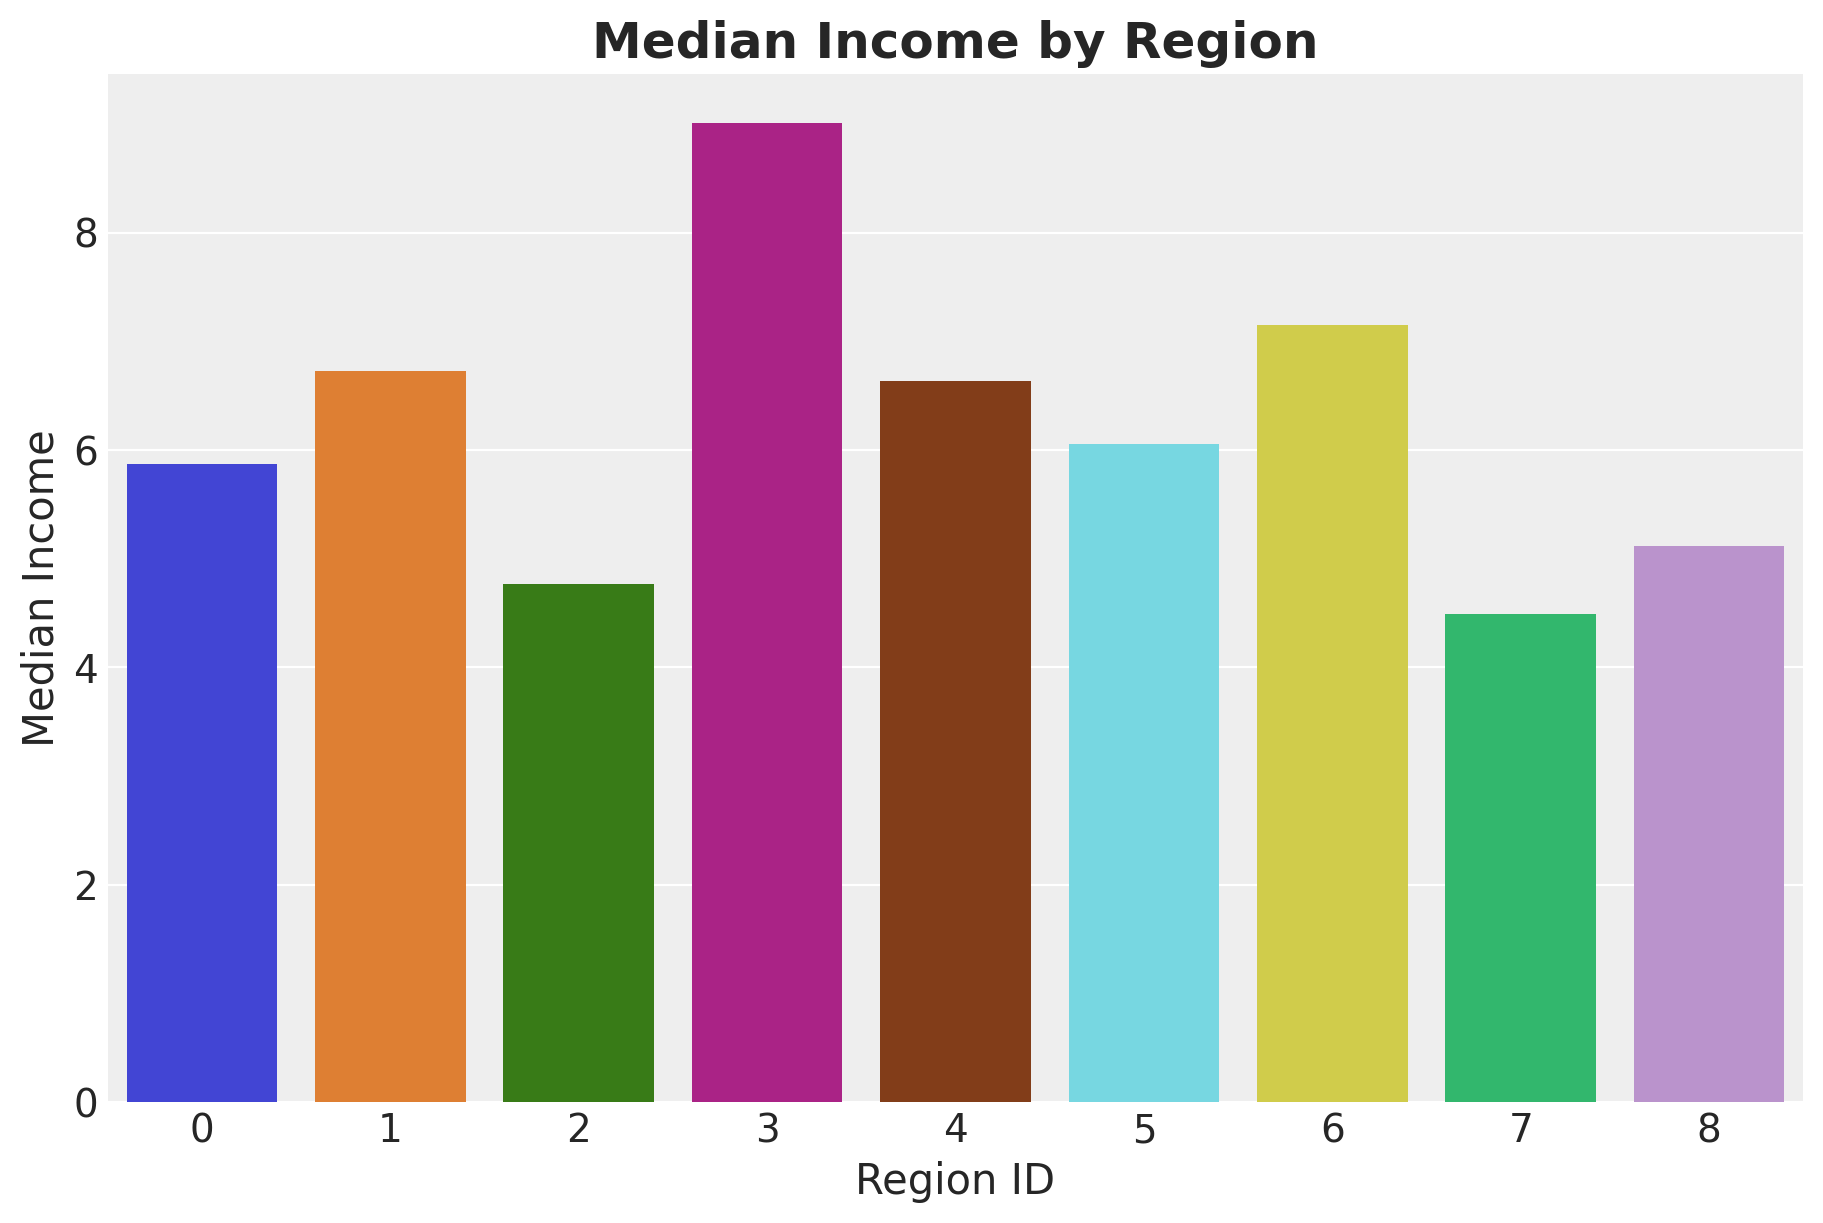

In [4]:
fig, ax = plt.subplots(figsize=(9, 6))
(
    market_df.group_by("region_id")
    .agg(pl.col("median_income").mean())
    .to_pandas()
    .pipe(
        (sns.barplot, "data"), x="region_id", y="median_income", hue="region_id", ax=ax
    )
)
ax.set(xlabel="Region ID", ylabel="Median Income")
ax.set_title(label="Median Income by Region", fontsize=18, fontweight="bold");

## Model Specification

As described in the previous notebooks, we can use a multi-level covariance model to estimate the elasticity by constraining how the intercept and slops vary. In the first notebook we did this just for the `median_income` variable. Here we extend it so that we have two covariance components for the intercept and two for the slope. We do thin in the non-centered parametrization (see [Statistical Rethinking in NumPyro - Chapter 14. Adventures in Covariance](https://fehiepsi.github.io/rethinking-numpyro/14-adventures-in-covariance.html)). Here is a mathematical description of the model:

\begin{align*}

\log(q) & \sim  \text{Normal}(\mu, \sigma ^2) \\
\mu & =  \alpha + \beta \log(p) \\
\alpha & = \alpha_{\text{intercept}, \text{region}} + \alpha_{\text{slope}, \text{region}} m \\
\beta & = \beta_{\text{intercept}, \text{region}} + \beta_{\text{slope}, \text{region}} m \\


\alpha_{\text{intercept}, \text{region}} & = z'_{\text{intercept}}[0] \\
\alpha_{\text{slope}, \text{region}} & = z'_{\text{slope}}[0] \\

\beta_{\text{intercept}, \text{region}} & = z'_{\text{intercept}}[1] \\
\beta_{\text{slope}, \text{region}} & = z'_{\text{slope}}[1] \\


z'_{\text{intercept}} &= \text{diag}(\sigma_{\alpha_{\text{intercept}}}^2, \sigma_{\beta_{\text{intercept}}}^2) L_{\text{intercept}} \: z_{\text{intercept}} \\

z'_{\text{slope}} &= \text{diag}(\sigma_{\alpha_{\text{slope}}}^2, \sigma_{\beta_{\text{slope}}}^2) L_{\text{slope}} \: z_{\text{slope}} \\

L_{\text{slope}} & \sim \text{LKJCholesky}(1) \\

z_{\text{intercept}} & \sim \text{Normal}(0, 1) \\

z_{\text{slope}} & \sim \text{Normal}(0, 1)

\end{align*}

We prepare the data (very similar to the previous notebooks) and then implement the model in `NumPyro`.

In [5]:
obs_idx = np.array(market_df.shape[0])

# For the region_id we use a label encoder to transform the categorical
# variable into integers (in more applications these tags won't be always integers so
# it is good to get used to these encoders.
regions_encoder = LabelEncoder()
regions_encoder.fit(market_df["region_id"].to_numpy())
regions_idx = regions_encoder.transform(market_df["region_id"].to_numpy())
regions = regions_encoder.classes_

log_price = market_df["log_price"].to_jax()
log_quantities = market_df["log_quantities"].to_jax()

# This is just an auxiliary variable to indicate we are modeling
# two covariance components.
effect = ["intercept", "median_income"]

Besides the usual data preparation, we need a map from the encoded category regions to the corresponding median income values:

In [6]:
region_median_income_mapping_df = market_df.select(
    ["region_id", "median_income"]
).unique()

region_median_income_mapping_df = region_median_income_mapping_df.with_columns(
    region_idx=regions_encoder.transform(
        region_median_income_mapping_df["region_id"].to_numpy()
    )
).sort("region_idx")

median_income = region_median_income_mapping_df["median_income"].to_jax()

Now we implement the model:

In [7]:
def model(log_price, regions_idx, median_income, log_quantities=None):
    dim = 2
    effects = 2
    n_obs = log_price.size
    n_regions = np.unique(regions_idx).size

    # Prior for the degrees of freedom of the Student-T distribution.
    nu = numpyro.sample("nu", dist.Gamma(concentration=20.0, rate=3))
    # Prior for the scale parameter of the Student-T distribution.
    sigma = numpyro.sample("sigma", dist.Exponential(rate=1.0 / 0.5))

    # concentration prior for the LKJ prior (this value assumes uniform correlation),
    concentration = jnp.ones(1)

    with numpyro.plate("effect", effects, dim=-1):
        # standard deviation of the effect.
        sigma_effect = numpyro.sample(
            "sigma_effect", dist.HalfNormal(scale=0.2 * jnp.ones(dim))
        )
        # correlation matrix
        chol_corr = numpyro.sample(
            "chol_corr",
            dist.LKJCholesky(dimension=dim, concentration=concentration),
        )

        with numpyro.plate("regions", n_regions, dim=-2):
            # z is the latent variable that we will use to compute the covariance matrix
            # in the non-centered parameterization.
            z = numpyro.sample("z", dist.Normal(loc=0, scale=1))

    # We compute the covariance matrix using the cholesky decomposition
    chol_cov = z @ (sigma_effect[None, ...] * chol_corr)
    # We extract the region effects
    alpha_region_effect = chol_cov[:, :, 0]
    beta_region_effect = chol_cov[:, :, 1]
    # Global intercept component (intercept and median income term)
    alpha_region_intercept = alpha_region_effect[0, :]
    alpha_region_median_income = alpha_region_effect[1, :]
    # Global slope factor of `log_price` (intercept and median income term)
    beta_region_intercept = beta_region_effect[0, :]
    beta_region_median_income = beta_region_effect[1, :]

    # Region specific intercept and slope
    alpha_region = numpyro.deterministic(
        "alpha_region",
        alpha_region_intercept + alpha_region_median_income * median_income,
    )
    beta_region = numpyro.deterministic(
        "beta_region",
        beta_region_intercept + beta_region_median_income * median_income,
    )

    # Likelihood mean
    mu = alpha_region[regions_idx] + beta_region[regions_idx] * log_price

    with numpyro.plate("data", n_obs):
        # We use a Student-T likelihood to model the residuals.
        numpyro.sample(
            "log_quantities",
            dist.StudentT(df=nu, loc=mu, scale=sigma),
            obs=log_quantities,
        )

Let's visualize the model:

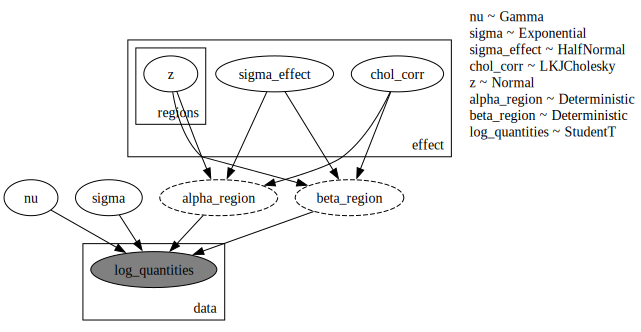

In [8]:
numpyro.render_model(
    model=model,
    model_kwargs={
        "log_price": log_price,
        "regions_idx": regions_idx,
        "median_income": median_income,
        "log_quantities": log_quantities,
    },
    render_distributions=True,
    render_params=True,
)

## Inference

We now use NUTS to sample from the posterior distribution of the model.

In [9]:
sampler = NUTS(model)
mcmc = MCMC(
    sampler=sampler,
    num_warmup=1_000,
    num_samples=4_000,
    num_chains=4,
)

rng_key, rng_subkey = random.split(rng_key)
mcmc.run(rng_subkey, log_price, regions_idx, median_income, log_quantities)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

We collect the results in an `InferenceData` object:

In [10]:
idata = az.from_numpyro(
    mcmc,
    coords={"effect": effect, "regions": regions},
    dims={
        "sigma_effect": ["effect"],
        "z": ["regions", "effect"],
        "alpha_region": ["regions"],
        "beta_region": ["regions"],
    },
)

## Model Diagnostics

In [11]:
# Count divergences
idata.sample_stats.diverging.sum().item()

0

In [12]:
az.summary(idata, var_names=["~z", "~chol_corr"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_region[0],2.752,0.052,2.654,2.848,0.000,0.000,18213.0,11582.0,1.0
alpha_region[1],2.994,0.056,2.890,3.100,0.000,0.000,16905.0,11383.0,1.0
alpha_region[2],2.440,0.035,2.376,2.507,0.000,0.000,17436.0,12368.0,1.0
alpha_region[3],3.606,0.139,3.344,3.867,0.001,0.001,16645.0,11384.0,1.0
alpha_region[4],2.989,0.052,2.894,3.088,0.000,0.000,18849.0,11999.0,1.0
alpha_region[5],2.827,0.057,2.720,2.935,0.000,0.000,16608.0,11715.0,1.0
alpha_region[6],3.082,0.049,2.994,3.178,0.000,0.000,18674.0,13358.0,1.0
alpha_region[7],2.343,0.029,2.291,2.398,0.000,0.000,18050.0,13305.0,1.0
alpha_region[8],2.541,0.039,2.470,2.615,0.000,0.000,16718.0,12278.0,1.0
beta_region[0],-3.558,0.124,-3.789,-3.324,0.001,0.001,18427.0,11093.0,1.0


We do not have divergences and the r-hat values look good!

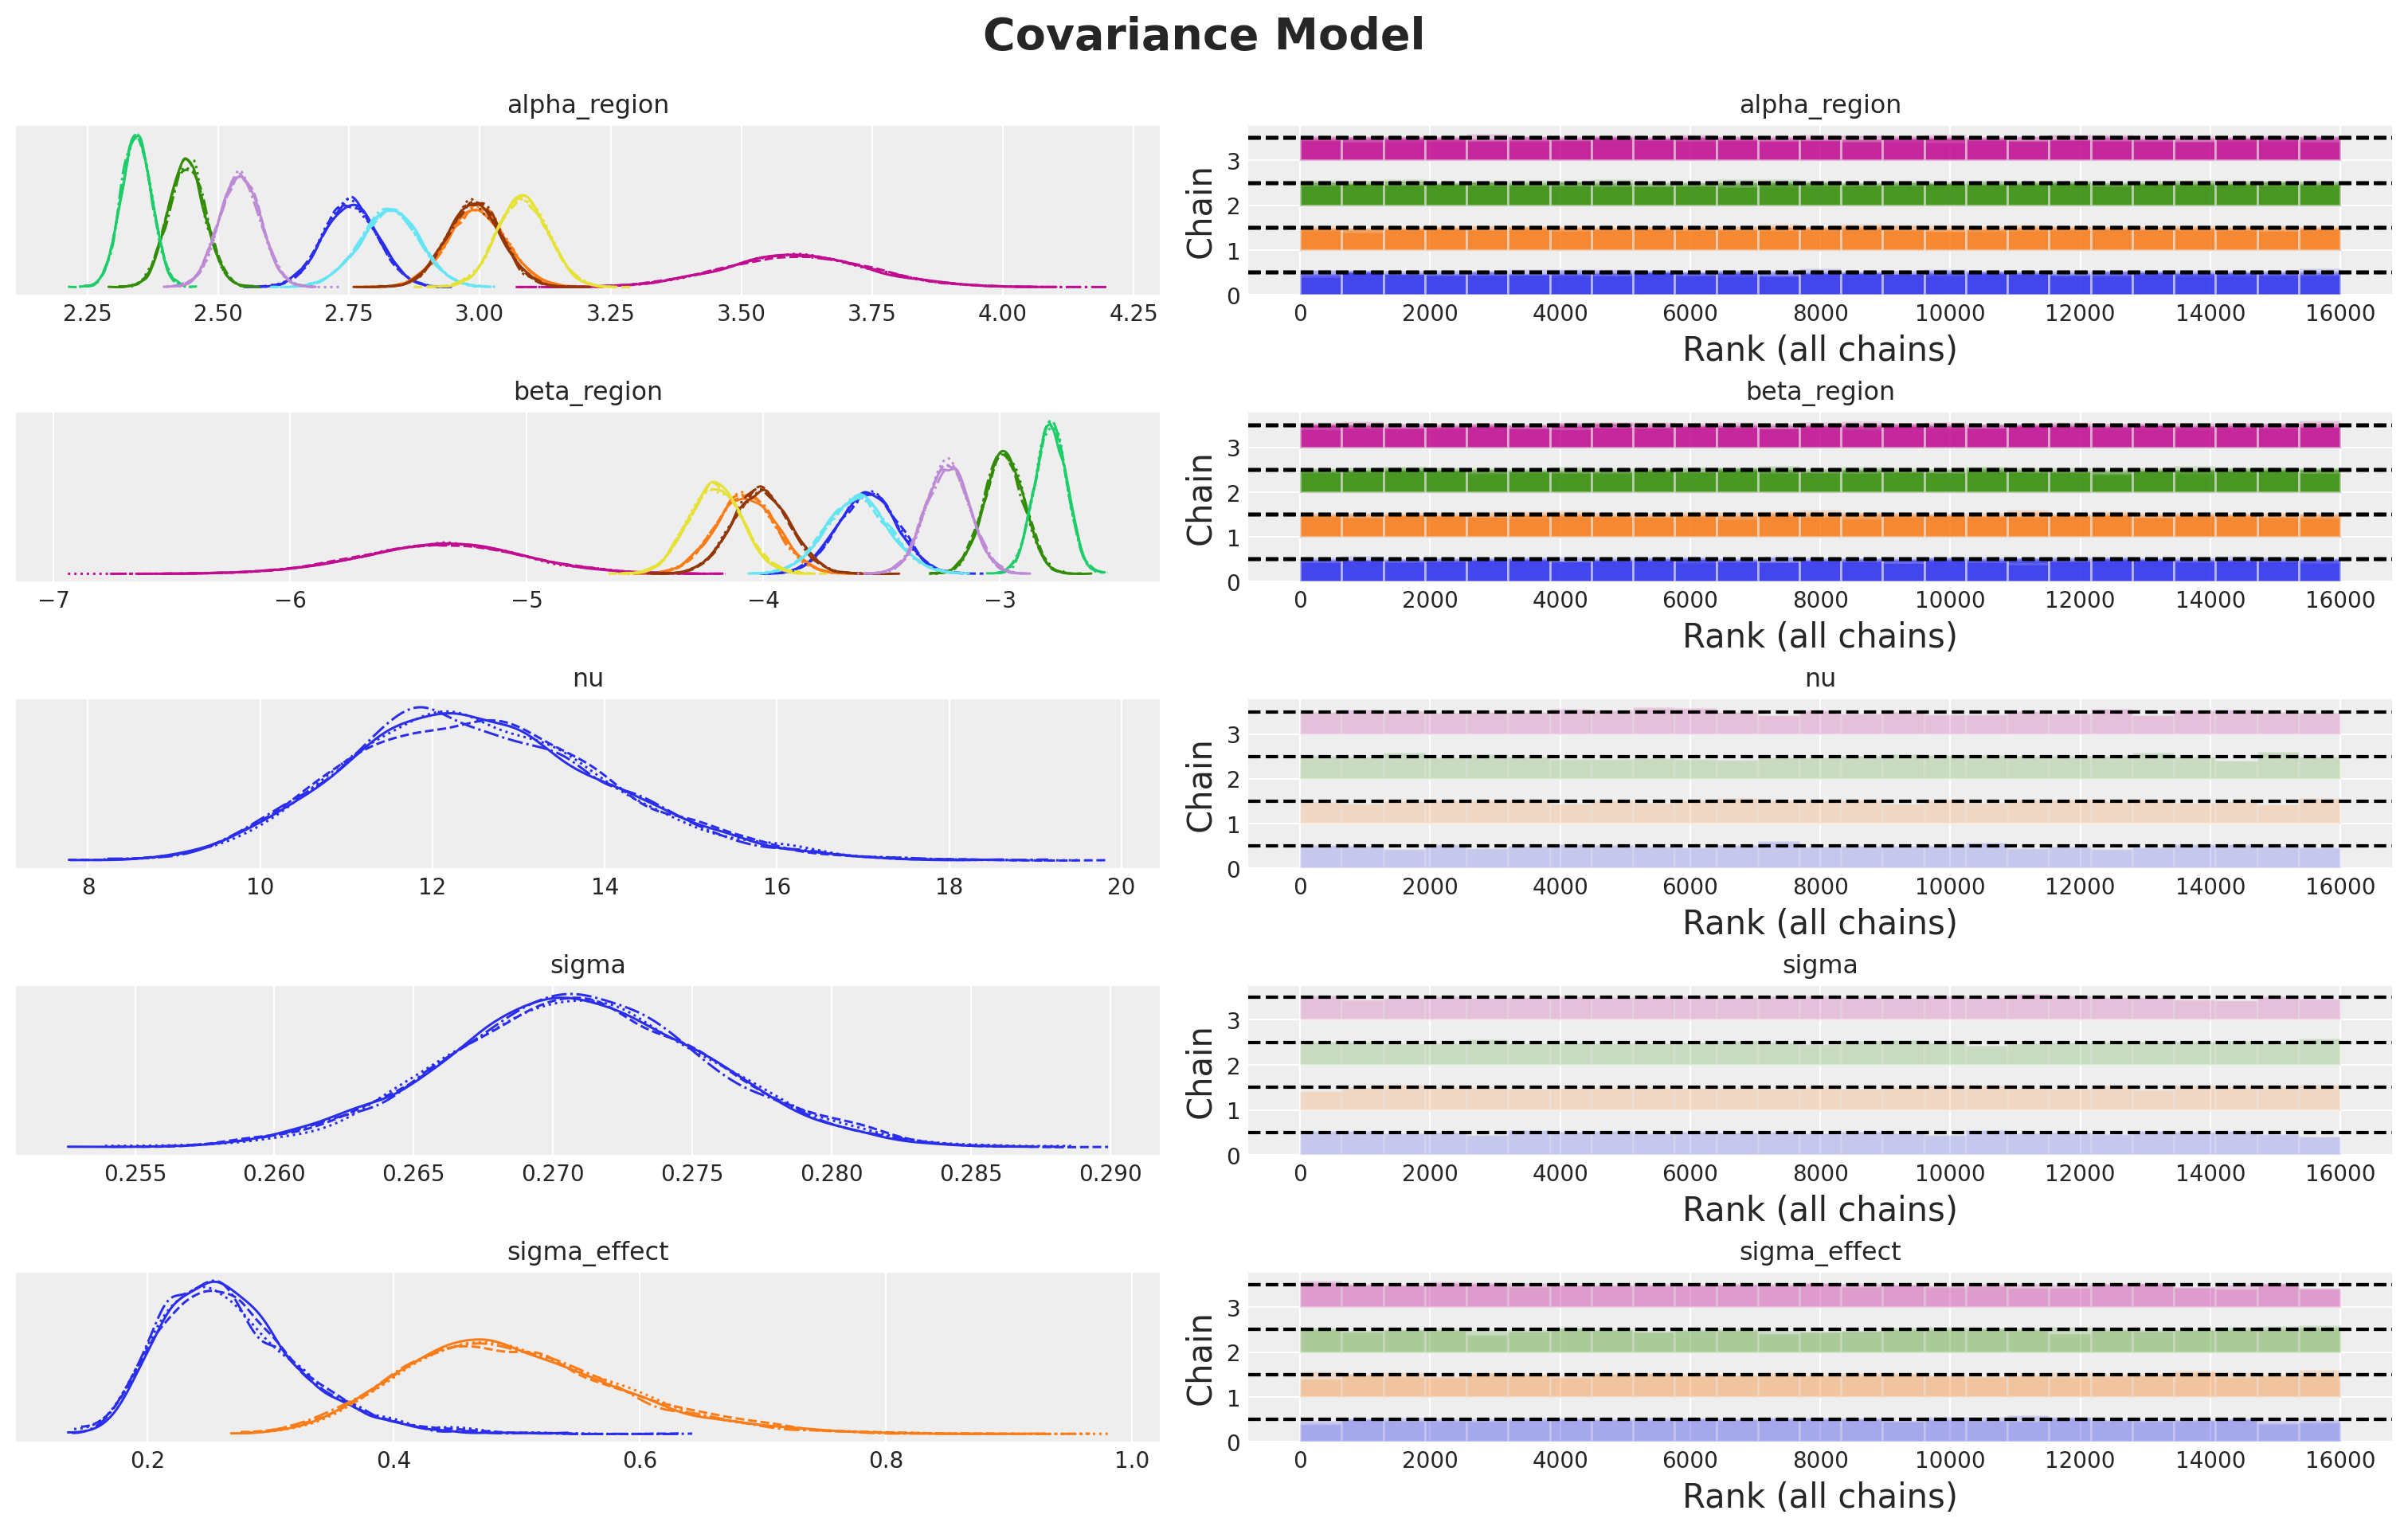

In [13]:
axes = az.plot_trace(
    data=idata,
    var_names=["~z", "~chol_corr"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (15, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Covariance Model", fontsize=20, fontweight="bold", y=1.05);

## Intercepts and Elasticities

Let's look into the estimates for the intercepts and elasticities:

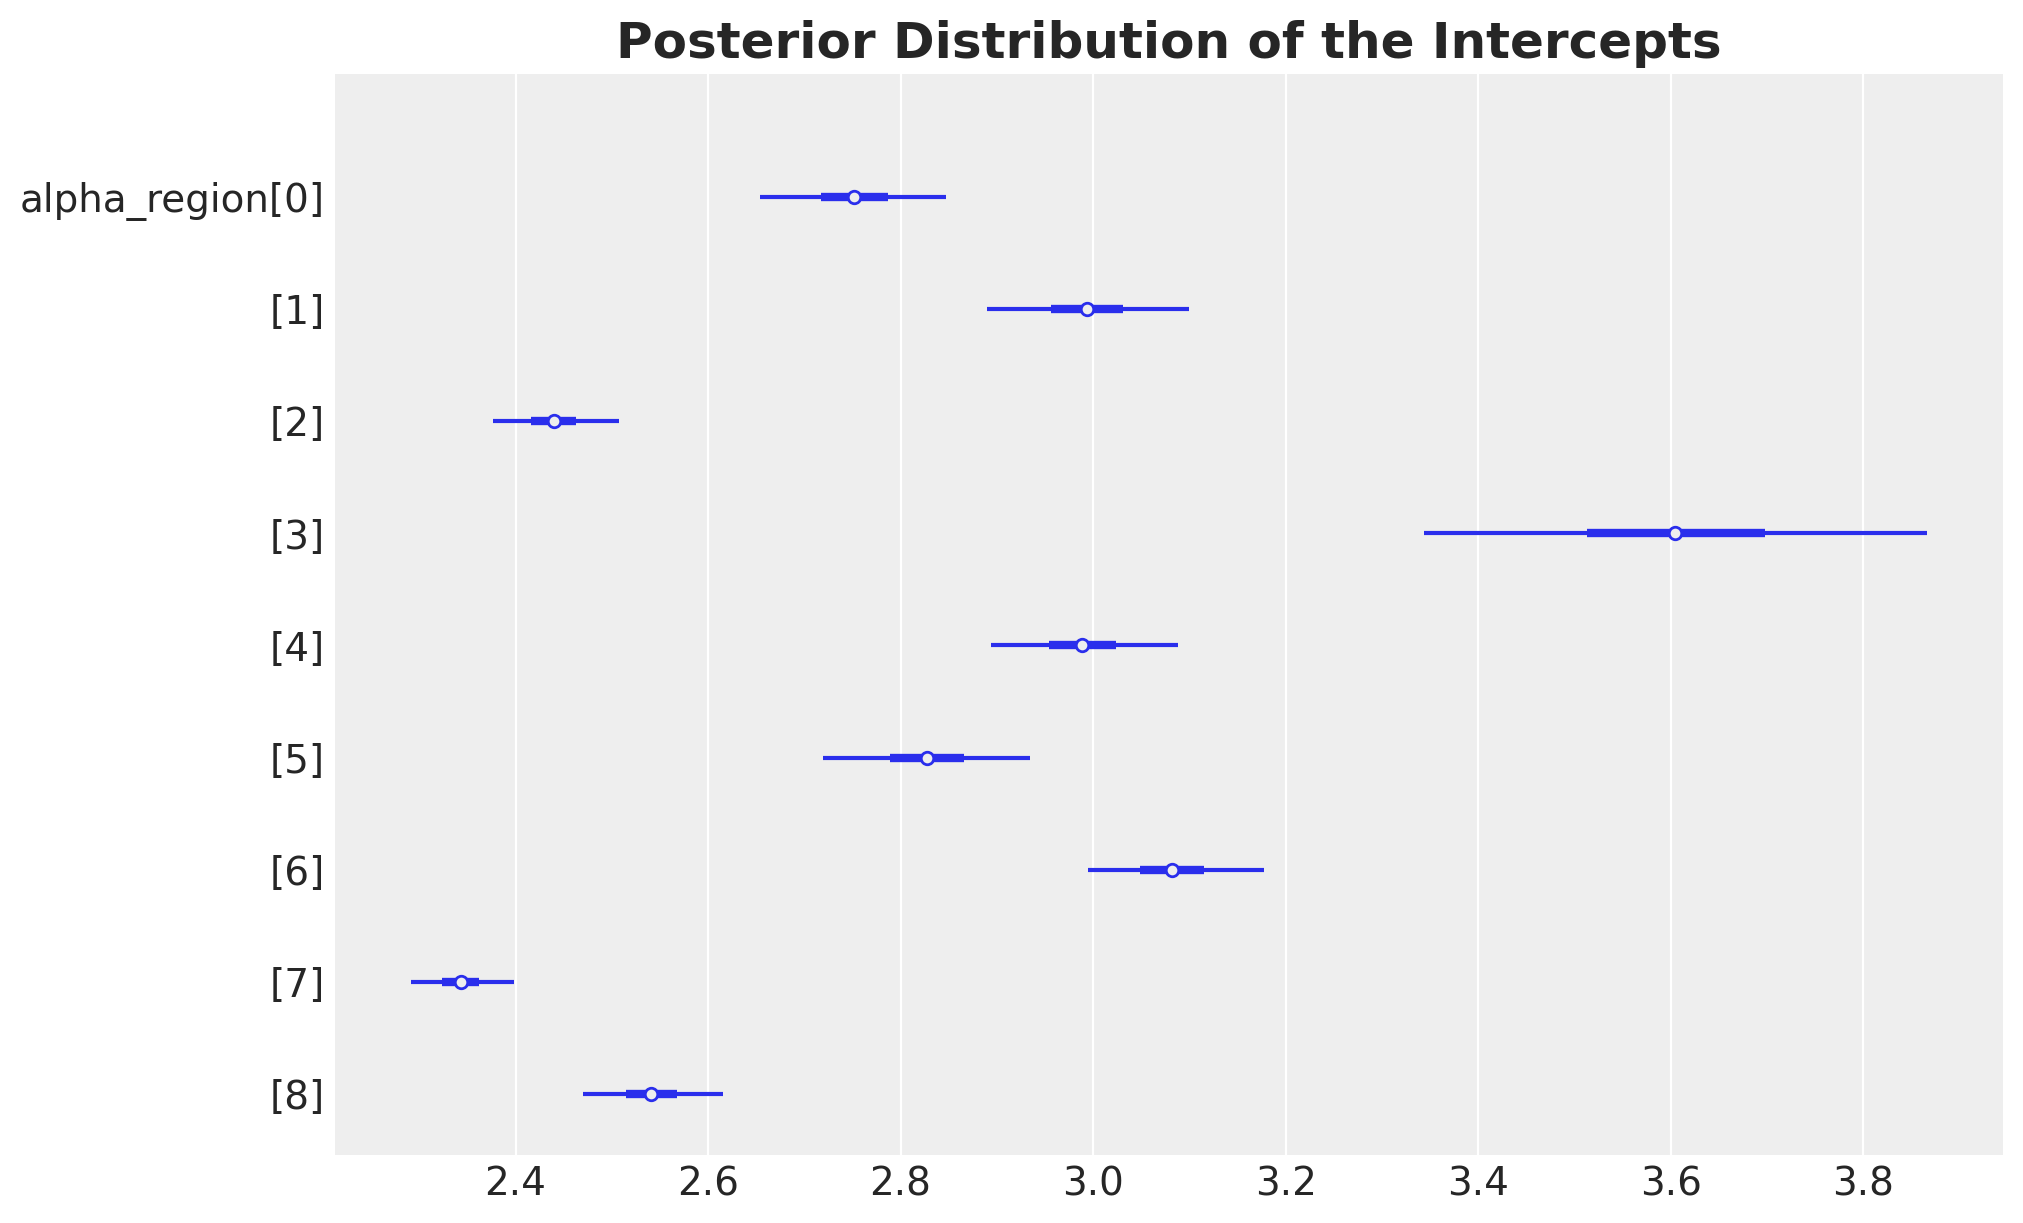

In [14]:
ax, *_ = az.plot_forest(
    data=idata,
    var_names=["alpha_region"],
    combined=True,
    figsize=(10, 6),
)
ax.set_title(
    label="Posterior Distribution of the Intercepts",
    fontsize=18,
    fontweight="bold",
);

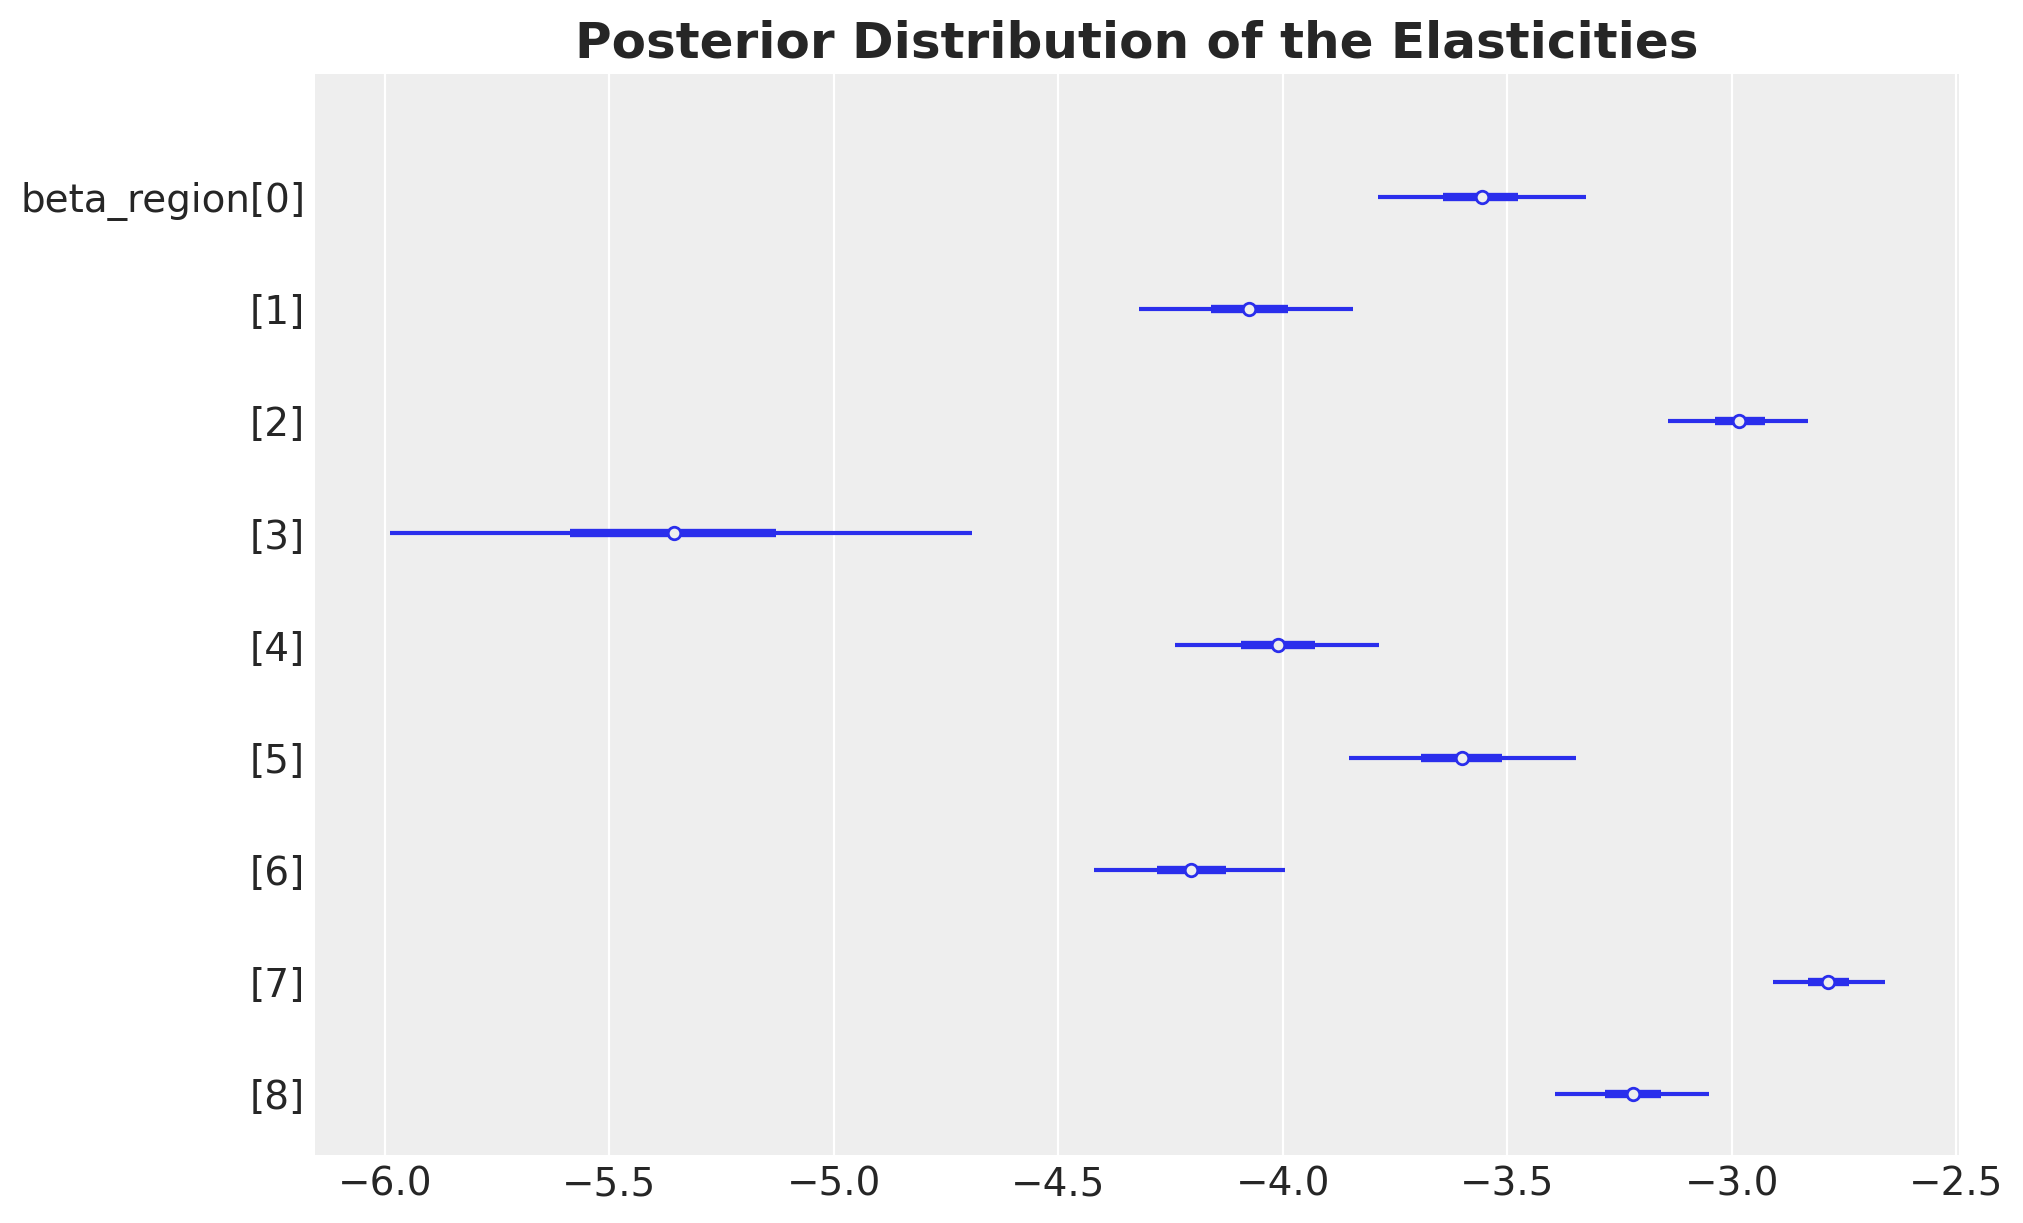

In [15]:
ax, *_ = az.plot_forest(
    data=idata,
    var_names=["beta_region"],
    combined=True,
    figsize=(10, 6),
)
ax.set_title(
    label="Posterior Distribution of the Elasticities",
    fontsize=18,
    fontweight="bold",
);

These results are very similar to the ones we obtained in the previous notebooks!